<a target="_blank" href="https://colab.research.google.com/github/victorlymarev/pandas/blob/main/notebooks/20-time-series-and-windows.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Временные ряды
#### [Ссылка на видео](https://youtu.be/XxMtQPDesjQ)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

Читаем данные

In [ ]:
path_ltc_sample = '../tables/ltc_sample.parquet' if os.path.exists('../tables/ltc_sample.parquet') else 'https://drive.google.com/uc?id=1XaThogOOqKjJj50LvfJ9WqutjMAC5AxA'

ltc = pd.read_parquet(path_ltc_sample)
ltc.head()

#### Рисуем графики

In [ ]:
plt.figure(figsize=(10, 5))
ltc.set_index('date')['price'].plot()
plt.xlabel('Дата')
plt.ylabel('Цена, $')
plt.title('Цена litecoin')
plt.show()

### Делаем лаги

In [ ]:
(ltc[['price']]
    .sample(5, random_state=123)
    .sort_index()
    .assign(shift_1 = lambda x: x['price'].shift(1))
    .assign(shift_2 = lambda x: x['price'].shift(2))
)

In [ ]:
(ltc[['price']]
    .sample(5, random_state=123)
    .sort_index()
    .assign(shift_minus_1 = lambda x: x['price'].shift(-1))
    .assign(shift_minus_2 = lambda x: x['price'].shift(-2))
)

#### Разница с предыдущим значением

In [ ]:
(ltc[['price']]
    .sample(5, random_state=123)
    .sort_index()
    .assign(diff_1 = lambda x: x['price'].diff(1))
    .assign(diff_manual_1 = lambda x: x['price'] - x['price'].shift(1))
 
    .assign(diff_2 = lambda x: x['price'].diff(2))
    .assign(diff_manual_2 = lambda x: x['price'] - x['price'].shift(2))
)

#### Прирост к предыдущему наблюдению

In [ ]:
(ltc[['price']]
    .sample(5, random_state=123)
    .sort_index()
    .assign(pct_change_1 = lambda x: x['price'].pct_change(1))
    .assign(pct_change_manual_1 = lambda x: x['price'] / x['price'].shift(1) - 1)

    .assign(pct_change_2 = lambda x: x['price'].pct_change(2))
    .assign(pct_change_manual_2 = lambda x: x['price'] / x['price'].shift(2) - 1)
)

## Приводим временной ряд к фиксированной частоте

In [ ]:
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    .head()
)

In [ ]:
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    .asfreq(freq='30 min')
    .head()
)

Заполняем последним доступным значением

In [ ]:
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    .asfreq(freq='30 min', method='ffill') # method='pad'
    .head()
)

In [ ]:
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    ['price']
    .asfreq(freq='30 min', method='backfill') # method='bfill'
    .head()
)

In [ ]:
# Можно поменять индекс первого наблюдения
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    .rename({pd.Timestamp('2013-11-13 15:00:56'): pd.Timestamp('2013-10-24 15:00')}) # не забудьте обернуть Timestamp
    .asfreq(freq='30 min', method='ffill') # method='bfill'
    .head()
)

## Окна

### resemple

In [ ]:
ltc.tail(10000).resample('30 min', on='date').apply(lambda x: list(x))

In [ ]:
ltc.resample('30 min', on='date')

In [ ]:
ltc.set_index('date').resample('30 min')

### После окон можно использовать те же функции, что и после groupby

In [ ]:
ltc.resample('30 min', on='date')['price'].mean()

#### Открытие (первое значение), максимум, минимум, закрытие (последнее значение)

In [ ]:
ltc.resample('30 min', on='date')['price'].ohlc()

#### agg

In [ ]:
ltc.resample('30 min', on='date')['price'].agg(['mean', 'max'])

#### Первое значение

In [ ]:
ltc.resample('30 min', on='date')['price'].first()

#### Последнее значение

In [ ]:
ltc.resample('30 min', on='date')['price'].last()

#### Можно использовать свои функции

In [ ]:
ltc.set_index('date')['price'].resample('d').agg(lambda x: x.iloc[::10].mean())

## rolling

Скользящее окно

In [ ]:
path_stocks = '../tables/stocks.parquet' if os.path.exists('../tables/stocks.parquet') else 'https://drive.google.com/uc?id=1weGquTtmR92mKYAeZhZCFHJjndyoSXZt'

stocks = pd.read_parquet(path_stocks)
stocks.head()

In [ ]:
stocks['Цена'].head()

In [ ]:
[list(window) for window in stocks['Цена'].round(3).rolling(window=4)][:10]

In [ ]:
stocks['Цена'].rolling(window=4).mean().head(8)

In [ ]:
stocks['Цена'].rolling(window=4, min_periods=1).mean().head(8)

#### Взять каждое второе наблюдение можно при помощи своей функции

In [ ]:
(stocks
    ['Цена']
    .rolling(window=10, min_periods=1)
    .agg(['mean', lambda x: x[::2].mean()])
    .set_axis(['Среднее', 'Среднее за каждое второе наблюдение'], axis=1)
    .head()
)

### expanding

Расширяющееся окно

In [ ]:
stocks['Цена'].expanding().sum()

In [ ]:
stocks['Цена'].cumsum()

In [ ]:
stocks['Цена'].expanding().mean()

### ewm

Окно с экспоненциально взвешенными операциями

In [ ]:
stocks['Цена'].ewm(alpha=0.5)

**adjust=True**
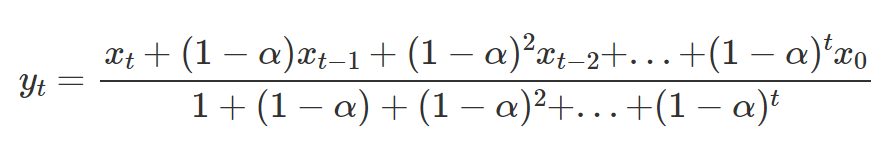

**adjust=False**

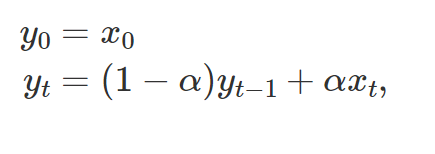

In [ ]:
stocks['Цена'].ewm(alpha=0.5).mean()

# Задания

#### Описание таблиц лежит [здесь](https://github.com/victorlymarev/pandas/tree/main/tables#%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D0%B5-%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%86)

Некоторые таблицы занимают много памяти, поэтому каждые 5-10 заданий лучше перезапускайте ноутбук.

В формулировке некоторых заданий может содержаться вариативность. Если у вас есть сомнения, что требуется в задании, попробуйте решить несколько вариантов. Если вы не понимаете задание, можете написать об этом в комментариях под видео.

В большинстве случаев внешний вид итоговой таблицы не определен. Выведите на экран наиболее адекватный вариант. То есть таблицу, из которой можно будет сделать выводы.

Курс пока находится в разработке. Вы можете помочь другим людям добавив свое решение [сюда](https://docs.google.com/forms/d/1HYTBz_KfssY3Jps2dC3n0YnEqa6WBb5OIhLo1d32Xzw/edit).

Посмотреть решения других людей можно [здесь](https://docs.google.com/spreadsheets/d/1pMDYO-9UneLbPPnEuQ2shig0TOJdQTU-zipifyAnZMk/edit?resourcekey#gid=1998648012)

### Задание 1

Для каждой даты выясните ли следующий день выходным (True если выходной, False если нет)

In [ ]:
import os
import pandas as pd

path_w_ends = '../tables/выходные.csv' if os.path.exists('../tables/выходные.csv') else 'https://drive.google.com/uc?id=1hAsoXSPTFihFmBuF-E0uSj9pX4gpojwC'

w_ends = pd.read_csv(path_w_ends)
w_ends.head()

In [ ]:
# напишите свой код здесь

### Задание 2

Постройте график суммарной выручки магазина 1 за каждый день. На том же графике разметите сглаженный график (тип сглаживания и длинну интервала сглаживания определите сами)

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_sample на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_sample = '../tables/sales_sample.parquet' if os.path.exists('../tables/sales_sample.parquet') else 'https://drive.google.com/uc?id=1BgxAxPauzC4LObY3N65PgAvnU3f5QRj2'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_sample)
sales.head()

In [ ]:
# напишите свой код здесь

### Задание 3

Для каждого месяца посчитать отношения числа проданных товаров в этом месяце к предыдущему, а так же прирост в выручке

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_sample на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_sample = '../tables/sales_sample.parquet' if os.path.exists('../tables/sales_sample.parquet') else 'https://drive.google.com/uc?id=1BgxAxPauzC4LObY3N65PgAvnU3f5QRj2'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_sample)
sales.head()

In [ ]:
# напишите свой код здесь

### Задание 4

Посчитать VaR и ES (на уровне 95%) для цены акций на 1 и на 10 торговых дней

VaR (value at risk) (на уровне 95%) - это 95 квантиль потерь (или пятый квантиль доходностей)
 
ES (expected shortfall) (на уровне 95%) - это средние убытки при условии, что состоялся неблагоприятный сценарий и убытки пробили 95% порог

In [ ]:
import os
import pandas as pd

path_stocks = '../tables/stocks.parquet' if os.path.exists('../tables/stocks.parquet') else 'https://drive.google.com/uc?id=1weGquTtmR92mKYAeZhZCFHJjndyoSXZt'

stocks = pd.read_parquet(path_stocks)
stocks.head()

In [ ]:
# напишите свой код здесь

### Задание 5

Для каждого сотрудника посчитать среднюю оценку за 3 месяца и за полгода. Предварительно приведите колонку с оценкой сотрудника к типу float

In [ ]:
import os
import pandas as pd

path_empl = '../tables/employees.parquet' if os.path.exists('../tables/employees.parquet') else 'https://drive.google.com/uc?id=1AARD5-eVlCxoApt5CYZebrC3Cqw42lvj'

empl = pd.read_parquet(path_empl)
empl.head()

In [ ]:
# напишите свой код здесь

### Задание 6

Для каждого сотрудника почитайте его среднюю оценку по состоянию на каждый месяц. То есть если сотрудник пропаботал год, то для каждого месяца его работы должна быть вычислена средняя оценки за предыдущие месяца его работы. Предварительно приведите колонку с оценкой сотрудника к типу float

In [ ]:
import os
import pandas as pd

path_empl = '../tables/employees.parquet' if os.path.exists('../tables/employees.parquet') else 'https://drive.google.com/uc?id=1AARD5-eVlCxoApt5CYZebrC3Cqw42lvj'

empl = pd.read_parquet(path_empl)
empl.head()

In [ ]:
# напишите свой код здесь

### Задание 7

Постройте график числа чеков в день за первые 30 дней работы, по каждому магазину

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_sample на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_sample = '../tables/sales_sample.parquet' if os.path.exists('../tables/sales_sample.parquet') else 'https://drive.google.com/uc?id=1BgxAxPauzC4LObY3N65PgAvnU3f5QRj2'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_sample)
sales.head()

In [ ]:
# напишите свой код здесь

### Задание 8

Посмотрите на среднюю оценку каждого сотрудника. Если в последние 3 месяца она не падает, то отметьте сотрудника как полезного. Если она не растет, то отметьте сотрудника как неполезного. Иначе поставьте NaN

In [ ]:
import os
import pandas as pd

path_empl = '../tables/employees.parquet' if os.path.exists('../tables/employees.parquet') else 'https://drive.google.com/uc?id=1AARD5-eVlCxoApt5CYZebrC3Cqw42lvj'

empl = pd.read_parquet(path_empl)
empl.head()

In [ ]:
# напишите свой код здесь

### Задание 9

По таблице prices найти товары которые были в продаже, потом исчезли, но затем вернулись

In [ ]:
import os
import pandas as pd

path_prices = '../tables/prices.parquet' if os.path.exists('../tables/prices.parquet') else 'https://drive.google.com/uc?id=1_KfYyYCsib8woanbP3VouLUpYp103dV5'

prices = pd.read_parquet(path_prices)
prices.head()

In [ ]:
# напишите свой код здесь

### Задание 10

Для каждого клиента и чека найти дату предыдущей покупки

То есть таблица должна содержать колонки номер чека (поле без дубликатов), id клиента, дата покупки, дата предыдущей покупки

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_sample на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_sample = '../tables/sales_sample.parquet' if os.path.exists('../tables/sales_sample.parquet') else 'https://drive.google.com/uc?id=1BgxAxPauzC4LObY3N65PgAvnU3f5QRj2'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_sample)
sales.head()

In [ ]:
# напишите свой код здесь

### Задание 11

Для каждого товара посчитайте, насколько цена товара сейчас выше своего среднего заначения за предыдущие 4 месяца

In [ ]:
import os
import pandas as pd

path_prices = '../tables/prices.parquet' if os.path.exists('../tables/prices.parquet') else 'https://drive.google.com/uc?id=1_KfYyYCsib8woanbP3VouLUpYp103dV5'

prices = pd.read_parquet(path_prices)
prices.head()

In [ ]:
# напишите свой код здесь

### Задание 12

На конец каждого месяца посчитайте, сколько дней проработал сотрудник. Если сотрудник увольнялся, необходимо учитывать предыдущий стаж


<details>

<summary>Подсказка</summary>
 
Здесь можно для каждого периода работы для каждого сотрудника посчитать, сколько дней он отработал. Отсортировать эти периоды по дате начала работы и посчитать накопленную сумму числа дней. Сдвинуть это значение на 1 период период и для первого периода начала работы заполнить нулем. Затем это значение можно смерджить с основной таблицей и прибавить это накопленное значение к числу дней работы с момента последнего устройства на работу.

</details>

In [ ]:
import os
import pandas as pd

path_events = '../tables/events.parquet' if os.path.exists('../tables/events.parquet') else 'https://drive.google.com/uc?id=1Phn06U4-BI0XqtYAgtlM6IuoXRIAGQlO'

events = pd.read_parquet(path_events)
events.head()

In [ ]:
path_empl = '../tables/employees.parquet' if os.path.exists('../tables/employees.parquet') else 'https://drive.google.com/uc?id=1AARD5-eVlCxoApt5CYZebrC3Cqw42lvj'

empl = pd.read_parquet(path_empl)
empl.head()

In [ ]:
# напишите свой код здесь

### Задание 13

Необходимо посчитать с какой скоростью кассир обслуживает клиетов. Но сделать это надо не просто разделив рабочий день на количество заказов, а немного умнее. 

Сначала необходимо выделить сессии. Сессией будем называть период, когда между заказами прошло менее 5 минут и когда этих заказов подряд было не менее 3.

Необходимо посчитать среднее время обслуживание клиента в рамках сессии. Для этого необходимо посчитать общую длинну сессий для каждого кассира и разделить ее на количество клиентов в сессиях минус число сессий у кассира.

<details>

<summary>Подсказка</summary>
    
Возможный вариант решения, который требует некоторых доработок
 
Сначала надо избавиться от дубликатов чеков. И оставить надо только 3 колонки: номер кассира, номер чека и дата покупки.

Далее еобходимо посчитать сколько больших сессий работы было у кассира. Для этого надо выделить наблюдения для каждого кассира, где разница между продажами была меньше 5 минут. И пометить их 1. Остальные -1. Далее вводим условие, что в сессии больше или равно 3 чеков. Это можно сделать, создав несколько колонок через shift, пометив начало сессии, конец сессии и период внутри сессии (который будет включать крайние значения) или как написано ниже.

Идем по столбцу из 1 и -1 скользящим окном размером 4. На каждом шаге окно домножаем на вектор [-1, 1, 1, 1] и считаем сумму. Если сумма равна 4, то ставим 1 - индикатор, что началась новая сессия, если сумма равна 4 или 2, значит сессия идет. Если значение равно нулю, то значит сессия закончилась на прошлом чеке и прошлое значение надо пометить как конец сессии. 

При расчете начала и конца сессии необходимо быть осторожным, что просиходит на краях, чтобы не получить сессию, которая не закончилась.

В конце счиатем количество сессий, число клиентов и время сессий (через merge_asof). Делим одно на другое.

</details>

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_2022 на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_2022 = '../tables/sales_2022.parquet' if os.path.exists('../tables/sales_2022.parquet') else 'https://drive.google.com/uc?id=17e7FwXVdsWc2aziK9s5KidIvPcfKt9F5'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_2022)
sales.head()

In [ ]:
# напишите свой код здесь